In [6]:
import transbigdata as tbd
import pandas as pd

data = pd.DataFrame([
            [34745, '20:27:43', 113.80684699999999, 22.623248999999998, 1, 27],
            [34745, '20:24:07', 113.809898, 22.627399, 0, 0],
            [34745, '20:24:27', 113.809898, 22.627399, 1, 0],
            [34745, '20:22:07', 113.811348, 22.628067, 1, 0],
            [34745, '20:10:06', 113.81988500000001,
             22.6478, 1, 54],
            [34745, '19:59:48', 113.820213,
             22.674967000000002, 0, 23],
            [34745, '20:11:06', 113.82048, 22.6423, 0, 57],
            [34745, '20:13:46', 113.82676699999999,
             22.630899, 0, 66],
            [34745, '19:43:18', 114.828217, 22.7069, 0, 62],
            [34745, '19:42:18', 113.83161899999999,
             22.716998999999998, 0, 69],
            [22233, '14:41:40', 113.878571, 22.571199, 0, 0],
            [22233, '14:42:00', 113.879135, 22.571617, 0, 7],
            [22233, '14:45:40', 113.886253, 22.573217, 0, 25],
            [22233, '14:49:00', 113.8899,
             22.56956700000001, 0, 0],
            [22233, '14:55:15', 113.91093400000001,
             22.552383, 1, 60],
            [22233, '19:02:12', 113.927116,
             22.543948999999998, 1, 41],
            [22233, '14:32:47', 113.92831399999999,
             22.556867999999998, 1, 57],
            [22233, '14:57:35', 113.934036, 22.555267, 1, 65],
            [22233, '20:54:11', 113.942467, 22.507566, 0, 21],
            [22233, '18:51:30', 113.964569, 22.541849, 0, 0]],
            columns=['Vehicleid',
                     'Time',
                     'slon',
                     'slat',
                     'OpenStatus',
                     'Speed'])

Amount of data
-----------------
Total number of data items:  20
Total number of individuals:  2
Data volume of individuals(Mean):  10.0
Data volume of individuals(Upper quartile):  10.0
Data volume of individuals(Median):  10.0
Data volume of individuals(Lower quartile):  10.0

Data time period
-----------------
Start time:  14:32:47
End time:  20:54:11

Sampling interval
-----------------
Mean:  1422.7222 s
Upper quartile:  596.75 s
Median:  210.0 s
Lower quartile:  125.0 s


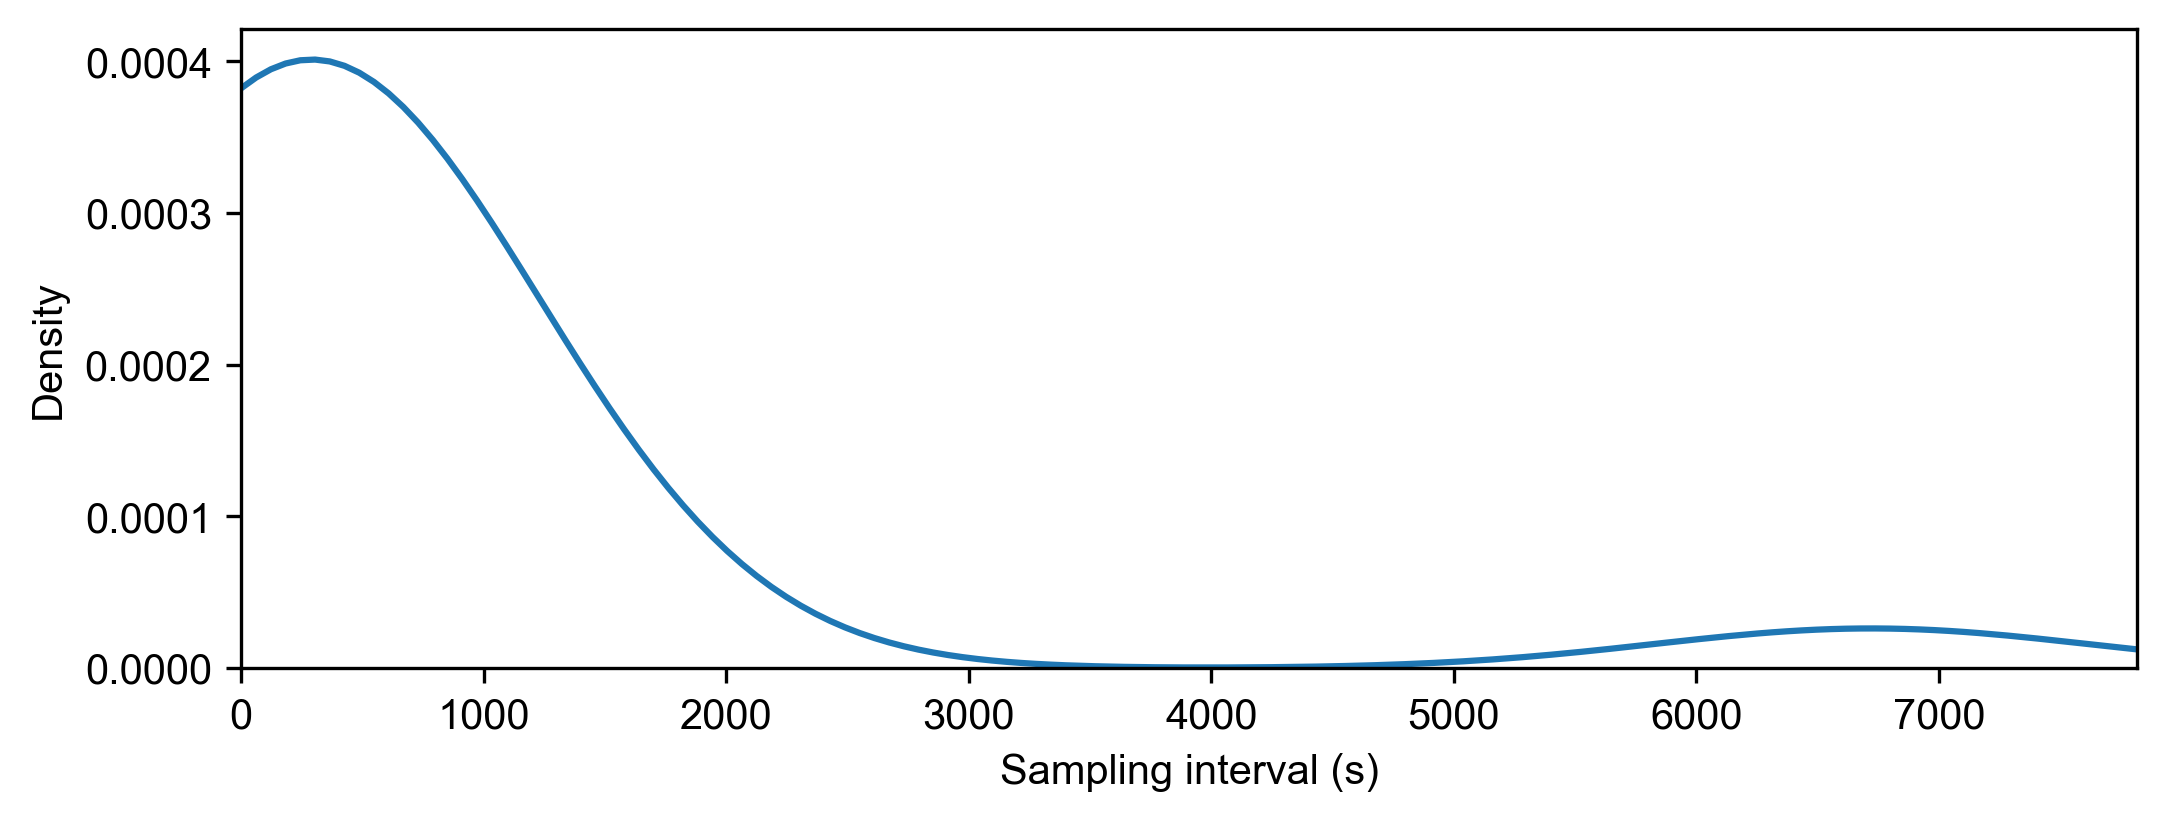

In [8]:
tbd.data_summary(data, show_sample_duration=True)

In [9]:
import transbigdata as tbd
data, stop = tbd.getbusdata('深圳市', ['1号线','2号线','3号线'])

Obtaining city id: 深圳市success
1号线
2号线
3号线
No such busline
